# ¿Qué es clustering?

El clustering es un metodo de machine learning no supervizado, en el cual introducimos un dataset y esperamos a que el algoritmo encuentre "cercania entre observaciones" que inicialmente no conocemos.  

Hay 3 algoritmos que usamos para el clustering: K-means, Hierarchical clustering y DBSCAN.  

Todos los modelos se evaluan con el SilhouetteVisualizer

# Librerias generales

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'  # Ejemplo de fuente alternativa

# Datos

make_blobs es una libreria que crea datos de prueba

In [70]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2, random_state=43, return_centers=True)

In [71]:
df_blobs = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': y})
df_centers = pd.DataFrame({'x1': c[:,0], 'x2': c[:,1]})

In [72]:
df_blobs

,x1,x2,y
0,-2.895366,8.328546,2
1,-6.622380,-4.333598,1
2,-7.012541,-6.733084,1
3,-3.942818,7.142052,2
4,1.971487,1.139175,3
...,...,...,...
495,-7.732402,1.177937,0
496,4.255747,0.445783,3
497,-3.640728,7.517340,2
498,-7.336113,-4.111863,1


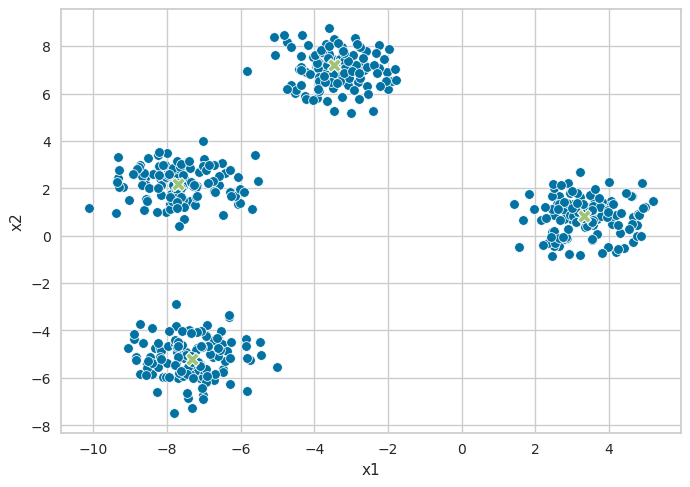

In [73]:
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100)
plt.show()

# k-Means

## ¿Qué es K-Means?

Dado un dataset $A \in \mathcal{M}_{n,p}$ y un entero $k \in \Z^+$, k-means arroja al espacio $\R^p$ $k$ vectores puestos aleatoriamente que llamaremos "clusters", seguido a cada uno de los $n$ puntos que reprecentan nuestros datos se le calcula la distancia a los clusters. Como siguiente paso, creamos un conjunto para cada cluster conformado por los datos a los cuales es mas cercano (estos conjuntos existen por el principio del buen orden) y a cada nuevo conjunto de datos le calculamos su centroide (media), estos seran $k$ nuevos cluster con los que repetiremos el proceso. Trivialmente el algoritmo converje, pero no siempre de la mejor forma, es muy sensible a los primeros $k$ clusters aleatorios.  

Para verlo visualmente consulte https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

## Ventajas y desventajas de k-means

Ventajas:  
-Alto performance  
-Simple  
-Resultados faciles de interpretar  
-Convergencia garantizada  
-Se adapta a nuevos datos  

Desventajas:  
-Replicabilidad  
-Muy sensible a los outliers  
-Buen performance cuando los datos estan agrupados en $p$-esferas (pues se usa la distancia euclidiana), pero por lo general esto no es así.  
-La $k$ se debe elegir antes de desplegar el modelo, pero es difícil saber cual es la apropiada de antemano  
-Afectado por la alta dimencionalidad  

## ¿Cuando usar k-means?  

1) Cuando por conocimiento se conoce $k$  
2) Quiero resultados rapidos  
3) Quiero resultados fáciles de interpretar  
4) Cuando los datos estan agrupados mas o menos de forma $p$-esferica
5) Cuando quiero escalar los datos

## Librerias de K-means

In [74]:
from sklearn.cluster import KMeans

## Aplicando k-means

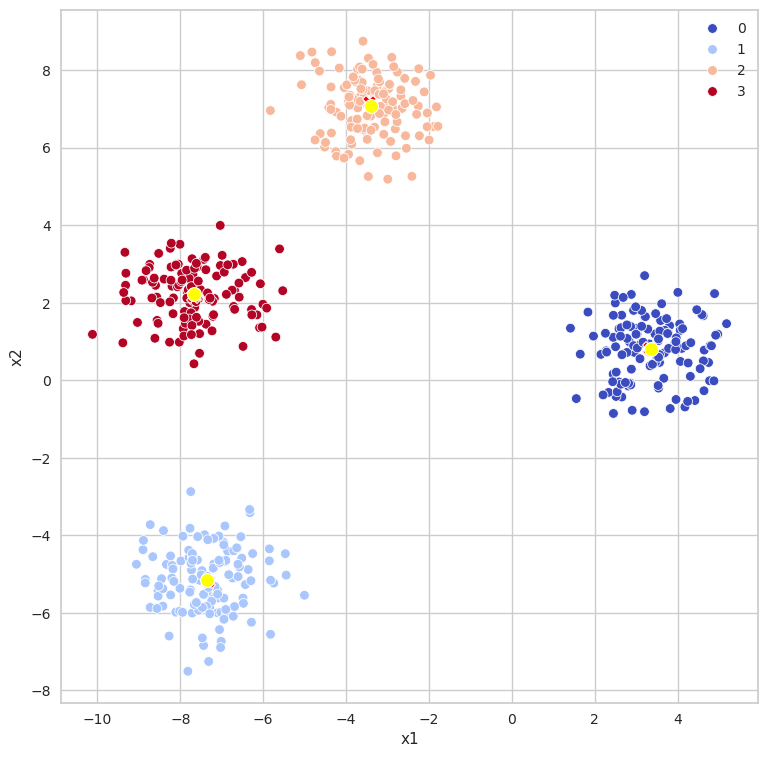

In [75]:
def plot_clusters(k):
    kmeans=KMeans(n_clusters=4, random_state=43)
    df_cluster = kmeans.fit_predict(X)
    df_blobs['cluster'] = df_cluster
    k_means_centers = kmeans.cluster_centers_
    df_k_means_centers = pd.DataFrame({'x1':k_means_centers[:,0], 'x2':k_means_centers[:,1]})
    fig = plt.figure(figsize=(9,9))
    sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster', palette='coolwarm')
    sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100, color='red')
    sns.scatterplot(data=df_k_means_centers, x='x1', y='x2', marker='o', s=100, color='yellow')
    plt.show()

plot_clusters(4)

vaya pendejada pa fácil

## Escogiendo K

Se utiliza el "metodo del codo". Tomamos la media de los errores cuadraticos en funcion de $k$ y escojemos el $k$ donde la gráfica tiene un codo.

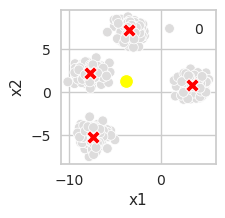

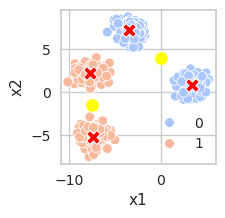

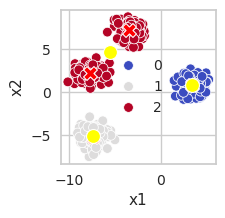

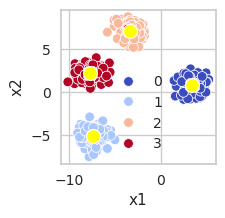

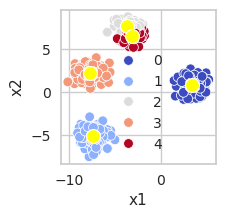

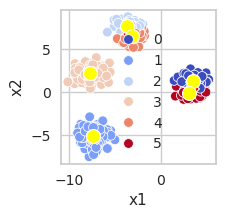

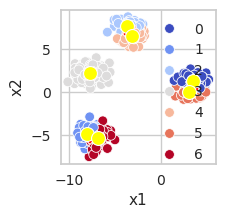

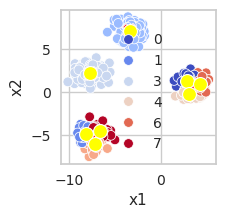

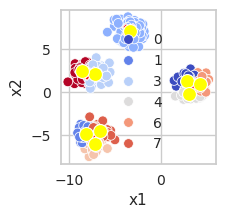

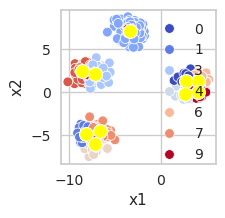

In [76]:
def plot_clusters(k):
    kmeans=KMeans(n_clusters=k, random_state=43)
    df_cluster = kmeans.fit_predict(X)
    df_blobs['cluster'] = df_cluster
    k_means_centers = kmeans.cluster_centers_
    df_k_means_centers = pd.DataFrame({'x1':k_means_centers[:,0], 'x2':k_means_centers[:,1]})
    fig = plt.figure(figsize=(2,2))
    sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster', palette='coolwarm')
    sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100, color='red')
    sns.scatterplot(data=df_k_means_centers, x='x1', y='x2', marker='o', s=100, color='yellow')
    plt.show()

for _ in range(1,11):
    plot_clusters(_)

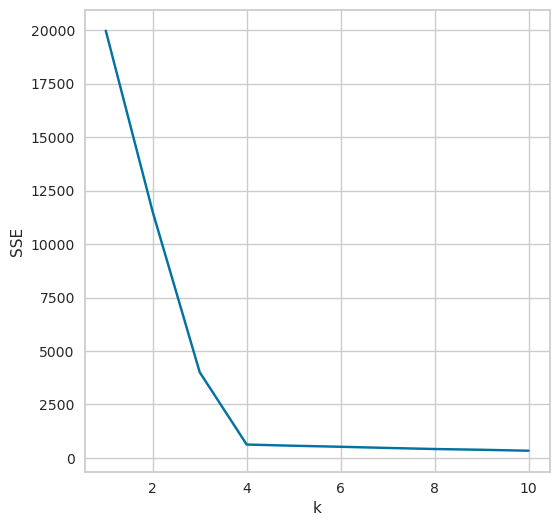

In [77]:
sse = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6,6))
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

Obviamente el número adecuado de clusters es 4

## Evaluando k-means

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4))

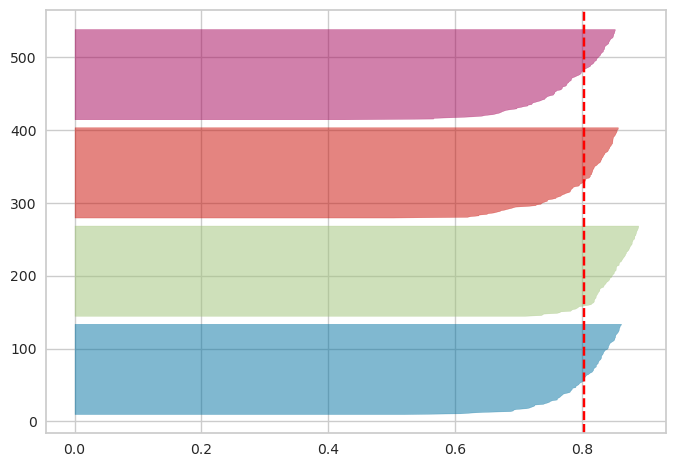

In [78]:
km = KMeans(n_clusters=4)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)

# Hierarchical Clustering

## ¿Qué es Hierarchical Clustering?

Es un algorítmo para hacer clustering que consiste en crear jerarquias acendentes desde jerarquias de un solo dato hasta la jerarquia de todos los datos. Cada jerarquia se agrupa con la mas cercana (determinada por otro algorítmo) para crear entre las dos (o podrian ser mas) la jerarquia superior.

![x](/root/Platzi/CurClus/images/x.png)

Hay varios algoritmos para encontrar la jerarquia mas cercana. Se podria usar la típica distancia entre conjuntos de $\R^p$ o alguna variante, pero el que tiene los mejores resultado se llama "Linkage-Ward" que agrupa los datos minimizando la varianza.

## Ventajas y desventajas de Hierarchical clustering

Ventajas:  
-No necesito el número de clusters antes de ejecutar el algorítmo  
-Simple  
-Resultados fáciles de interpretar  
-Única ejecición  
-Ayuda visual de un dendograma  

Desventajas:  
-Lento con datasets muy grandes  
-No tiene un objetivo matemático  
-Demasiado sensible a los outliers
-Se requiere mas poder de computo

## ¿Cúando usar hierarchical clustering?

1) Cuando quiera comprender los resultados de manera visual  
2) Cuando tenga un dataset pequeño
3) Cuando no hay forma de saber la cantidad de clusters
4) Cuando quiero resultados rápidos.

## Librerias de hierarchical clustering

In [79]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

## Aplicando hierrachical clustering

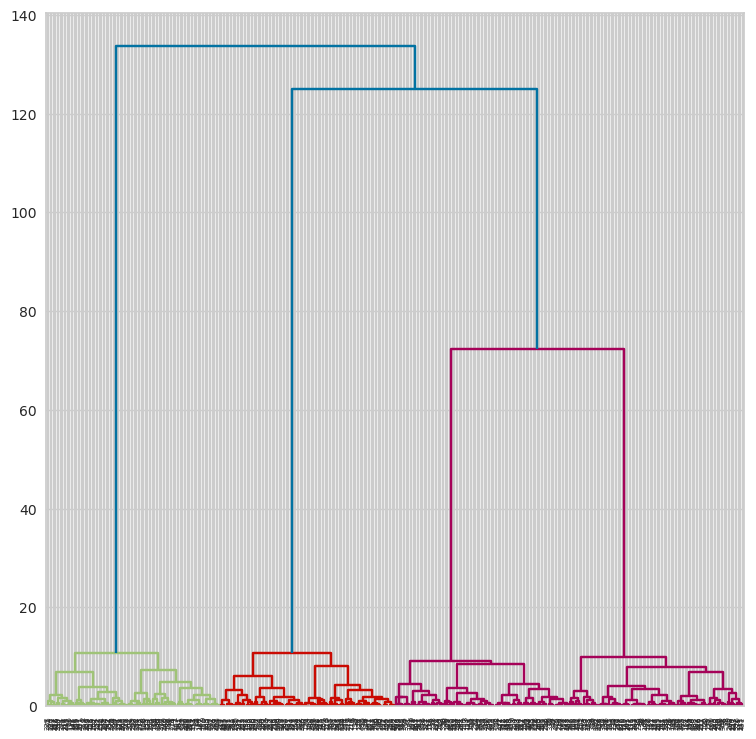

In [80]:
fig = plt.figure(figsize=(9,9))
dendrogram_plot=dendrogram(linkage(X, method='ward'))
plt.show()

In [81]:
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(X)

In [82]:
df_blobs['cluster'] = y_hc

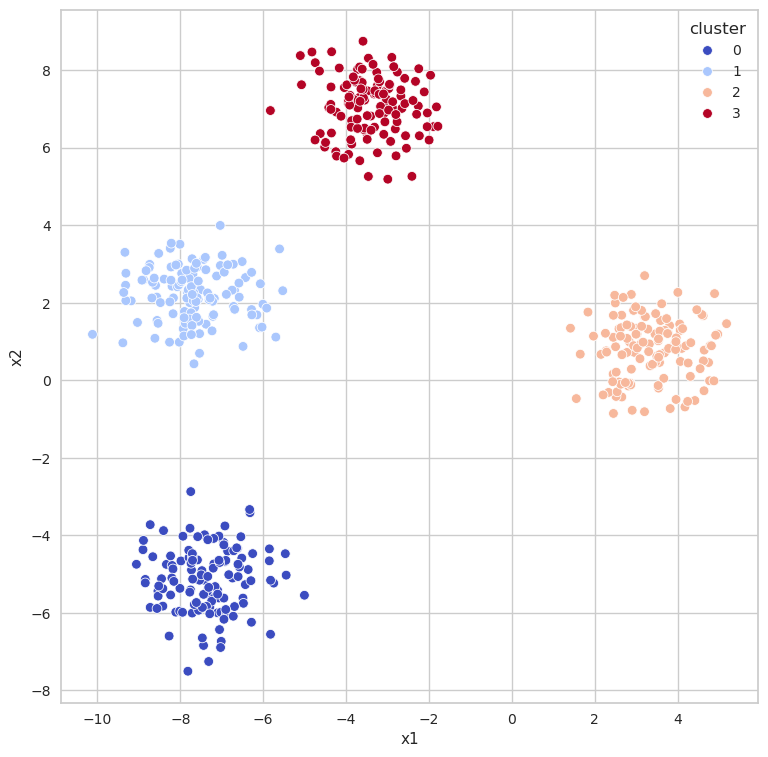

In [83]:
fig = plt.figure(figsize=(9,9))
sns.scatterplot(data = df_blobs, x='x1', y='x2', hue='cluster', palette='coolwarm')
plt.show()

## Evaluando hierarchical clustering

# DBSCAN

Density based spatial clustering of application with noise

## ¿Qué es DBSCAN?

Es un algorítmo de clusterización que se basa en la densidad de los datos. A cada dato $\vec{x}$ le asigna una densidad en base a un radio $\varepsilon$ y un mínimo de vecinos $n$ dentro de la bola $B(\vec{x},\varepsilon)$. Las zonas con alta densidad seran clusters y las zonas con baja densidad seran el espacio que separa los clusters. Este es tal vex el mejor algorítmo para hacer clustering porque puede trabajar con datos egrupados de cualquier forma.

![aaa](/root/Platzi/CurClus/images/aaa.png)

El algorítmo toma un punto $\vec{x}$ aleatoriamente y mira si hay $n$ vecinos en $B(\vec{x},\varepsilon)$. Si los hay, $\vec{x}$ sera un dato "core", y a todos sus vecinos se les aplica el mismo proceso. Si no, el algorítmo salta aleatoriamente a otro dato $\vec{y}$. El algorítmo crea un nuevo vector donde asigna de 1 en adelante el cluster al que pertenece cada dato. Los datos que no son catalogados como core se llaman ruido y se les asigna el -1.

Para verlo visualmente consultar https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/  

Este algoritmo encuentra clusters de forma muy eficiente pero puede ser que por una fijación del $n$ muy grande y el $\varepsilon$ muy pequeño, hay puntos que tal vez no son cores, y quedan sin ser asignados a ningún cluster, o puede pasar que al escojer un $n$ muy pequeño y un $\varepsilon$ muy grande dos grupos de datos que deberian ser clusters distintos conformen uno solo.

## Ventajas y desvenjatas de DBSCAN

Ventajas:  
-No hay que fijar el número de clusters antes de ejecutar el algorítmo  
-No se ve afectado por outliers  
-Puede encontrar clusters de formas y tamaños arbitrarios  

Desventajas:  
-Demasiado sensible a los paramentros $n$ y $\varepsilon$.  
-Los puntos fronterizos pueden quedar en cualquiera de los clusters donde es frontera.

## Cuando usar DBSCAN

1) Cuando desconosco el número de clusters  
2) No hay formas esfericas en los datos  
3) Densidades similares entre clusters

## Librerias de DBSCAN

In [84]:
from sklearn.cluster import DBSCAN

## Datos de prueba

In [85]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2, random_state=43, return_centers=True)

df_blobs = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1]})

df_centers = pd.DataFrame({'x1': c[:,0], 'x2': c[:,1]})

In [86]:
X_m, y_m, = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame({'x1': X_m[:,0], 'x2': X_m[:,1]})

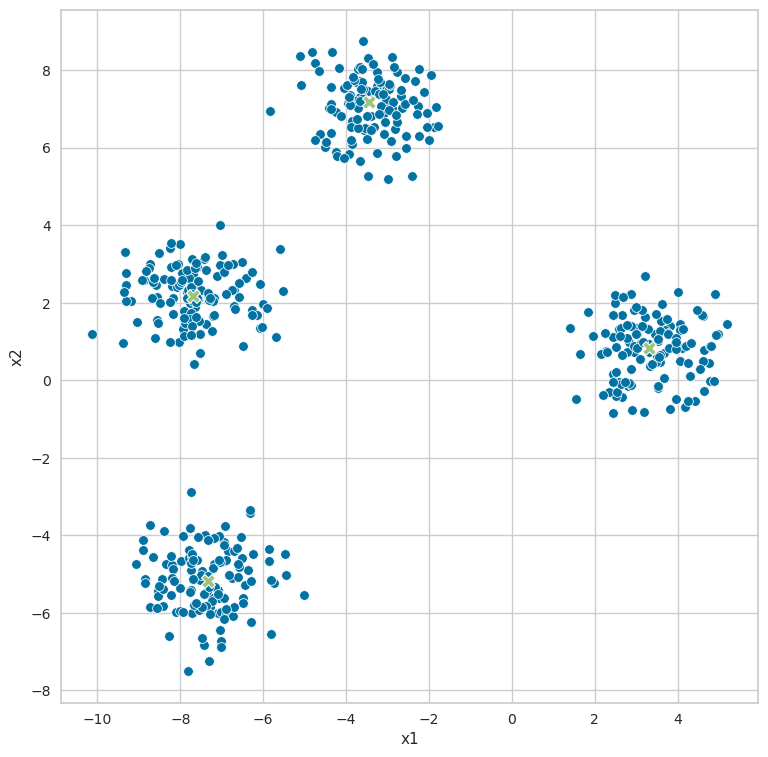

In [87]:
fig = plt.figure(figsize=(9,9))
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100)
plt.show()

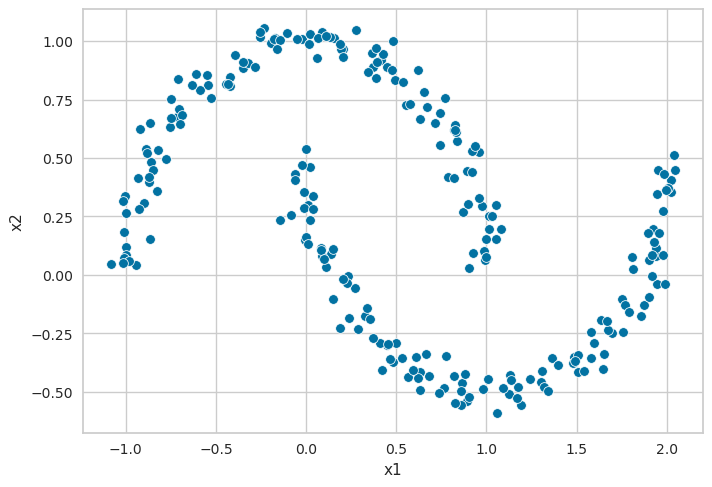

In [88]:
sns.scatterplot(data=df_moons, x='x1', y='x2')
plt.show()

## Aplicando DBSCAN

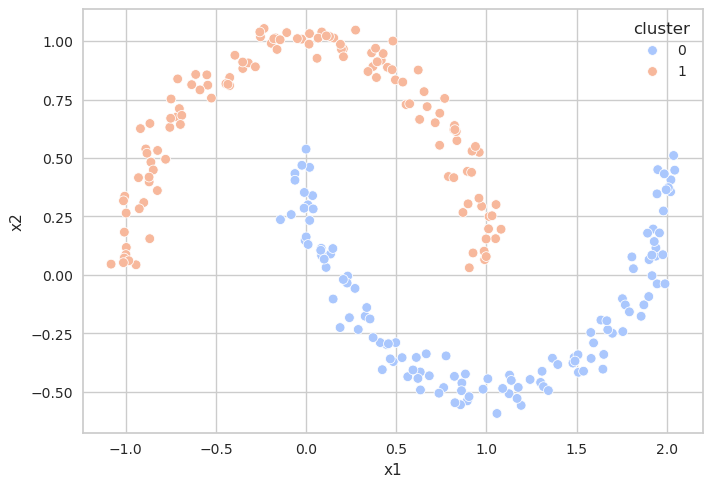

In [89]:
dbscan_cluster = DBSCAN(eps=0.2, min_samples=4)
y_m_predict = dbscan_cluster.fit_predict(X_m)
df_moons['cluster'] = y_m_predict
sns.scatterplot(data=df_moons, x='x1', y='x2', hue='cluster', palette='coolwarm')
plt.show()

## Escojiendo $n$ y $\varepsilon$

Parecido a k-means, para encontrar el $\varepsilon$ adecuado utilizaremos la técnica de la "rodilla".

In [90]:
from sklearn.neighbors import NearestNeighbors

In [91]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

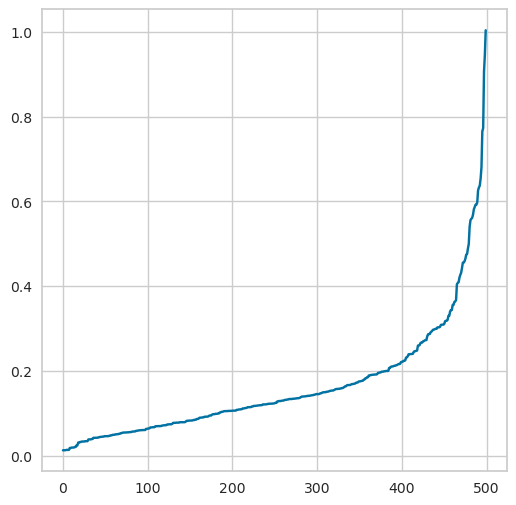

In [92]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = plt.figure(figsize=(6,6))
plt.plot(distances)
plt.show()

En este caso el $0.2 \leq \varepsilon \leq 0.4$.

In [93]:
eps_vals = np.arange(0.2, 0.45, 0.05)
n_vals = np.arange(1,11, 1)

In [94]:
from itertools import product

In [95]:
DBSCAN_params = list(product(eps_vals, n_vals))
sil_scores=[]

for p in DBSCAN_params:
    y_pred = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(X)
    sil_scores.append(silhouette_score(X, y_pred))

In [96]:
df_params_tunning = pd.DataFrame.from_records(DBSCAN_params, columns=['eps', 'min_samples'])
df_params_tunning['sil_scores'] = sil_scores

In [97]:
pivot_data = pd.pivot_table(df_params_tunning, values='sil_scores', index='min_samples', columns='eps')

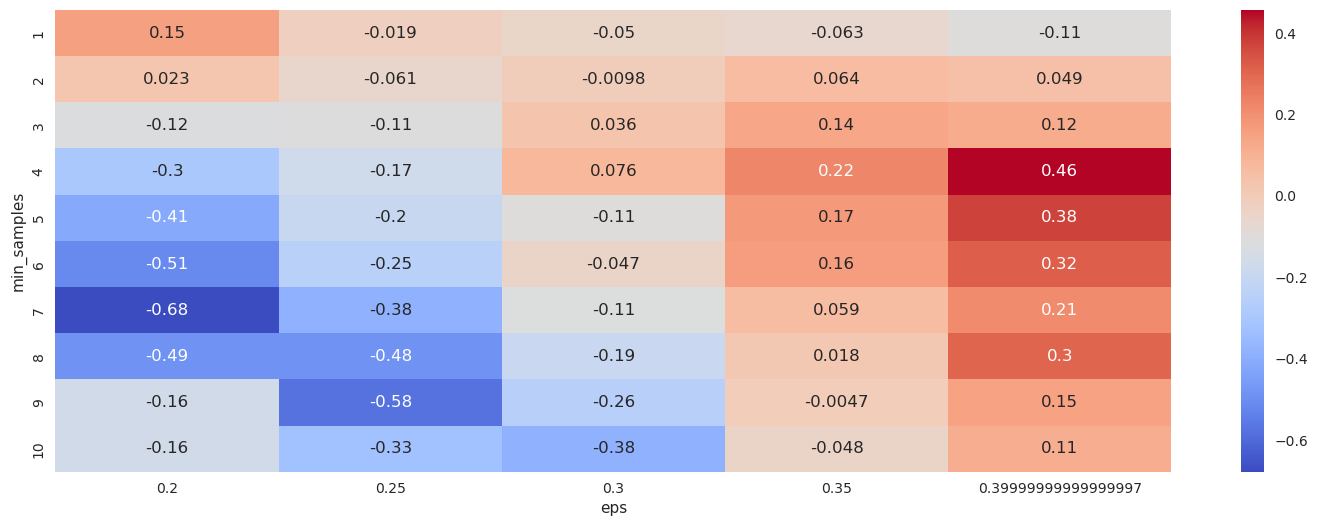

In [98]:
fig, ax= plt.subplots(figsize=(18,6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm')
plt.show()

Como queremos maximizar el indice de silueta, en este caso tomamos $n = 4$ y $\varepsilon = 0.4$.

## Evaluando DBSCAN